# Stix Dispersion Solver

[stix]: ../../api_static/plasmapy.dispersion.analytical.stix_.rst
[bellan2012]: https://doi.org/10.1029/2012JA017856
[stix1992]: https://link.springer.com/book/9780883188590

This notebook details the functionality of the [stix()][stix] function. This is an analytical solution of equation 8 in [Bellan 2012][bellan2012], the function is defined by [Stix 1992][stix1996] in Section 1.2 to be:

$$
        (S\sin^{2}(\theta) + P\cos^{2}(\theta))\left ( \frac{ck}{\omega} \right)^{4}
            - [
                RL\sin^{2}(\theta) + PS(1 + \cos^{2}(\theta))
            ]\left ( \frac{ck}{\omega} \right)^{2} + PRL = 0
$$

where,

$$
        \mathbf{B_o} = B_{o} \mathbf{\hat{z}}   
         \cos \theta = \frac{k_z}{k} \\
        \mathbf{k} = k_{\rm x} \hat{x} + k_{\rm z} \hat{z}
$$

$$
        S = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega^{2}_{c,s}}\hspace{2.5cm}
        P = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2}}\hspace{2.5cm}
        D = \sum_{s}
            \frac{\omega_{c,s}}{\omega}
            \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega_{c,s}^{2}}
$$

$$
        R = S + D \hspace{1cm} L = S - D
$$

$\omega$ is the wave frequency, $k$ is the wavenumber, $\theta$ is the wave propagation angle with respect to the background magntic field $\mathbf{B_{0}}$, $s$ corresponds to plasma species $s$, $\omega_{p,s}$ is the plasma frequency of species and $\omega_{c,s}$ is the gyrofrequency of species $s$.

<div class="alert alert-info">
Note

The derivation of this dispersion relation assumed:
    
 * zero temperature for all plasma species ($T_{s}=0$)
 * quasi-neutrallity
 * a uniform background magntic field $\mathbf{B_o} = B_{o} \mathbf{\hat{z}}$
 * no D.C. electric field $\mathbf{E_o}=0$
 * zero-order quantities for all plasma parameters (densities, electric-field, magnetic field, particle speeds, etc.) are constant in time and space
 * first-order perturbations in plasma parameters vary like $\sim e^{\left [ i (\textbf{k}\cdot\textbf{r} - \omega t)\right ]}$
    
</div>  

Due to the cold plasma assumption, this equation is valid for all $\omega$ and $k$ given $\frac{\omega}{k_{z}} \gg v_{Th}$ for all thermal speeds $v_{Th}$ of all plasma species and $k_{x} r_{L} \ll 1$ for all gyroradii $r_{L}$ of all plasma species. The relation predicts $k \to 0$ when any one of P, R or L vanish (cutoffs) and $k \to \infty$ for perpendicular propagation during wave resonance $S \to 0$.
 

## Contents

1. [Wave Normal to the Surface](#Wave-normal-to-the-surface)
2. [Comparison with Bellan](#Comparison-with-bellan)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import functools
import scipy

from astropy import units as u
from astropy.constants import eps0
from astropy.constants.si import c

from plasmapy.dispersion.analytical.stix_ import stix
from plasmapy.dispersion.analytical.two_fluid_ import two_fluid
from plasmapy.formulary import speeds
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency
from plasmapy.formulary.lengths import inertial_length
from plasmapy.particles import Particle

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

## Wave Normal to the Surface

To calculate the normal surface waves propagating through a magnetized uniform cold plasma. The wave which is normal to the surface, is the locus of the phase velocity $\textbf{v}_{phase} = \frac{\omega}{k} \, \hat{k}$ where $\hat{k} = \frac{\textbf{k}}{k}$. The equation for the wave normal surface can be derived via the prior equations, resulting in the form of

$$
    Au^{4} + Bu^{2} + C = 0
$$

where $u = \frac{\omega}{ck}$. To begin we define the required parameters to compute the wave numbers.

In [2]:
# define input parameters
inputs_1 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e12 * u.cm**-3,
    "B": 0.43463483142776164 * u.T,
    "w": 41632.94534008216 * u.rad / u.s,
}

# define a meshgrid based on the number of theta values
omegas, thetas = np.meshgrid(
    inputs_1["w"].value, inputs_1["theta"].value, indexing="ij"
)
omegas = np.dstack((omegas,) * 4).squeeze()
thetas = np.dstack((thetas,) * 4).squeeze()

# compute k values
k = stix(**inputs_1)

[Quantity]: https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity

The computed wavenubmers in units (rad/m) are returned in a dictionary (shape $N \times M \times 4$), with the keys representing $\theta$ and the values (instances of Astropy [Quantity]) being the wavenumbers. The first dimension maps to the $w$ array, the second dimension maps to the $\theta$ array, and the third dimension maps to the four roots of the Stix polynomial.
* $k[0]$ is the square root of the positive quadratic solution
* $k[1] = -k[0]$
* $k[2]$ is the square root of the negative quadratic solution
* $k[3] = -k[2]$

Below the values for $u_{x}$ and $u_{z}$ are calculated.

In [3]:
# calculate ux and uz

u_v = {}

mask = np.imag(k) == 0

va_1 = speeds.va_(inputs_1["B"], inputs_1["n_i"], ion=inputs_1["ions"])
for arr in k:
    val = 0
    for item in arr:
        val = val + item**2
    norm = (np.sqrt(val) * va_1 / inputs_1["w"]).value ** 2
    u_v = {
        "ux": norm * omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value),
        "uz": norm * omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value),
    }

Let's plot the results.

/Users/elliotjohnson/opt/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/elliotjohnson/opt/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


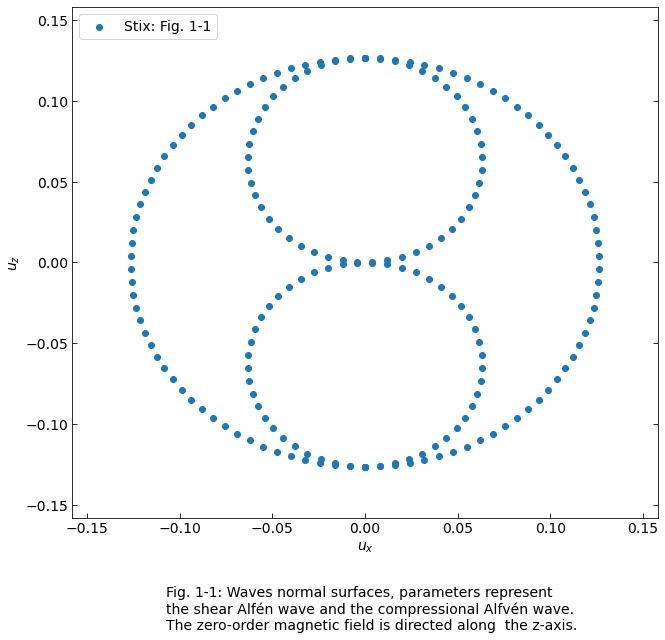

In [4]:
# plotting the results

fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.scatter(
    u_v["ux"],
    u_v["uz"],
    label="Stix: Fig. 1-1",
)

# adjust axes
plt.xlabel(r"$u_{x}$", fontsize=fs)
plt.ylabel(r"$u_{z}$", fontsize=fs)

pad = 1.25
plt.ylim(min(u_v["uz"]) * pad, max(u_v["uz"]) * pad)
plt.xlim(min(u_v["ux"]) * pad, max(u_v["ux"]) * pad)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
)

# plot caption
txt = (
    f"Fig. 1-1: Waves normal surfaces, parameters represent \nthe shear Alfén wave "
    "and the compressional Alfvén wave. \nThe zero-order magnetic field is directed along "
    " the z-axis."
)

plt.figtext(0.25, -0.04, txt, ha="left", fontsize=fs)
plt.legend(loc="upper left", markerscale=1, fontsize=fs)

plt.show()

Here we can define the parameters for all the plots in Stix [1992] and then reproduced them in the same fashion.

In [5]:
# define inputs
inputs_2 = {
    "theta": np.linspace(0, np.pi, 100) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434 * u.T,
    "w": (37125810) * u.rad / u.s,
}

inputs_3 = {
    "theta": np.linspace(0, np.pi, 100) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434534 * u.T,
    "w": (2 * 10**10) * u.rad / u.s,
}

inputs_4 = {
    "theta": np.linspace(0, np.pi, 100) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434600 * u.T,
    "w": (54 * 10**9) * u.rad / u.s,
}

inputs_5 = {
    "theta": np.linspace(0, np.pi, 100) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (58 * 10**9) * u.rad / u.s,
}

# define a list of all inputs
stix_inputs = [inputs_1, inputs_2, inputs_3, inputs_4, inputs_5]

Following on, the same method implemented on the first set of input parameters can be implemented on the rest. After which the result for all inputs can be plotted.

In [6]:
stix_plt = {}

ux = {}
uz = {}

for i in range(len(stix_inputs)):
    stix_plt[i] = {}


for i, inpt in enumerate(stix_inputs):
    omegas, thetas = np.meshgrid(inpt["w"].value, inpt["theta"].value, indexing="ij")
    omegas = np.dstack((omegas,) * 4).squeeze()
    thetas = np.dstack((thetas,) * 4).squeeze()

    k = stix(**inpt)

    mask = np.imag(k) == 0

    va = speeds.va_(inpt["B"], inpt["n_i"], ion=inpt["ions"])

    for arr in k:
        val = 0
        for item in arr:
            val = val + item**2
        norm = (np.sqrt(val) * va / inpt["w"]).value ** 2
        stix_plt[i] = {
            "ux": norm
            * omegas[mask]
            * np.sin(thetas[mask])
            / (k.value[mask] * c.value),
            "uz": norm
            * omegas[mask]
            * np.cos(thetas[mask])
            / (k.value[mask] * c.value),
        }

Plotting the results.

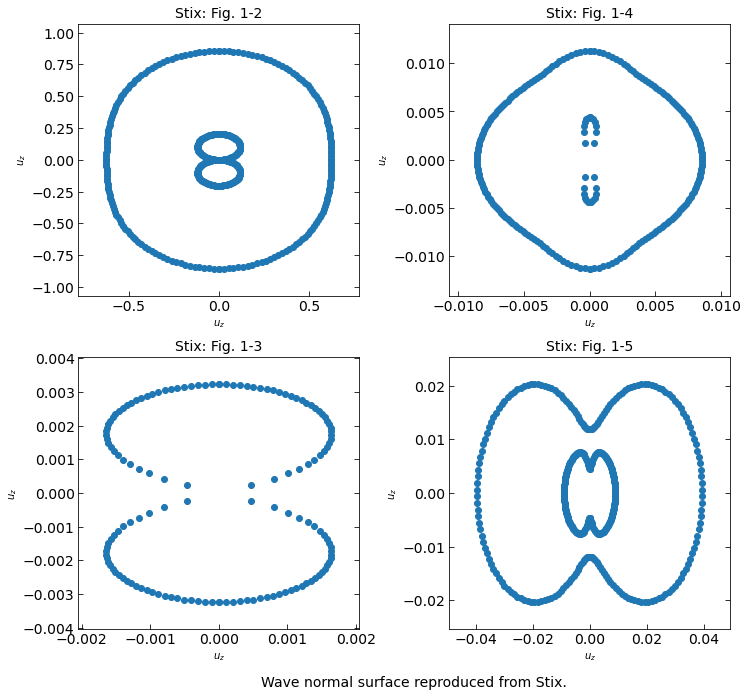

In [7]:
# create figure
fig, axs = plt.subplots(2, 2, figsize=[figwidth, figheight])


for i in range(2):
    for j in range(2):
        axs[i, j].scatter(
            stix_plt[i + 2 * j + 1]["ux"], stix_plt[i + 2 * j + 1]["uz"], label="dfwd"
        )
        axs[i, j].set_title("Stix: Fig. 1-" + str(i + 2 * j + 2), fontsize=fs)

        # adjust axes
        axs[i, j].set(
            ylabel=r"$u_{z}$",
            xlabel=r"$u_{z}$",
        )

        pad = 1.25
        axs[i, j].set_ylim(
            min(stix_plt[i + 2 * j + 1]["uz"]) * pad,
            max(stix_plt[i + 2 * j + 1]["uz"]) * pad,
        )
        axs[i, j].set_xlim(
            min(stix_plt[i + 2 * j + 1]["ux"]) * pad,
            max(stix_plt[i + 2 * j + 1]["ux"]) * pad,
        )

        axs[i, j].tick_params(
            which="both",
            direction="in",
            labelsize=fs,
            right=True,
            length=5,
        )


# plot caption
txt = (
    f"Wave normal surface reproduced from Stix."
)

plt.tight_layout()
plt.figtext(0.35, -0.02, txt, ha="left", fontsize=fs)


plt.show()

## Comparison with Bellan

Below we run a comparison between the solution provided in [Bellan 2012][bellan2012] and our own solutions computed from [stix()][stix]. To begin we first create a function that reproduce the Bellan plot.


In [8]:
# function creating Bellan style normalized
def norm_bellan_plot(**inputs):
   
    w = inputs["w"]
    k = inputs["k"]
    theta = inputs["theta"]
    
    if w.shape == k.shape:
        pass
    elif w.size ==1 or k.size == 1:
        pass
    elif w.ndim > 2 or k.ndim > 2:
        raise ValueError
    elif k.shape[0] != w.shape[0]:
        raise ValueError
    elif k.ndim > w.ndim:
        w = np.repeat(w[..., np.newaxis], k.shape[1], axis=1)
    elif k.ndim < w.ndim:
        k = np.repeat(k[..., np.newaxis], w.shape[1], axis=1)
    
    if theta.ndim != 1 or theta.size != w.shape[-1]:
        raise ValueError
    
    try:
        ion = inputs["ion"]
    except KeyError:
        ion = inputs["ions"][0]
    va = speeds.va_(inputs["B"], inputs["n_i"], ion=ion)
    
    mag = ((w / (k * va)).to(u.dimensionless_unscaled).value)**2
    theta = theta.to(u.radian).value
    
    xnorm = mag * np.sin(theta)
    ynorm = mag * np.cos(theta)
    
    return np.array([xnorm, ynorm])


Now we can solve the Bellan solution for identical plasma parameters, in the first instance a cold plasma limit of $T_{e} = \, {\rm K}$ and $T_{H+} = \, {\rm K}$ are assumed. In the second instance a warm plasma limit of $T_{e} = \, {\rm K}$ and $T_{H+} = \, {\rm K}$ are assumed.

In [9]:
# defining all inputs
base_inputs = {
    "k": (2 * np.pi * u.rad) / (0.56547 * u.m),
    "theta": np.linspace(0, 0.49 * np.pi, 50) * u.rad,
    "ion": Particle("He+"),
    "n_i": 6.358e19 * u.m**-3,
    "B": 400e-4 * u.T,
}

hot_inputs = {
    **base_inputs,
    "T_e": 20 * u.eV,
    "T_i": 10 * u.eV,
}

cold_inputs = {
    **base_inputs,
    "T_e": 0.1 * u.eV,
    "T_i": 0.1 * u.eV,
}

# calculating the solution from two fluid
w_tf_hot = two_fluid(**hot_inputs)
w_tf_cold = two_fluid(**cold_inputs)

A normalized array is required for plotting.

In [10]:
plt_tf_hot = {}
for key, val in w_tf_hot.items():
    plt_tf_hot[key] = norm_bellan_plot(**{**hot_inputs, "w": val})

plt_tf_cold = {}
for key, val in w_tf_cold.items():
    plt_tf_cold[key] = norm_bellan_plot(**{**cold_inputs, "w": val})

Stix needs to recalculated using the Bellan inputs as a base.

In [11]:
stix_inputs = {
    **base_inputs,
    "ions": [base_inputs["ion"]]
}
del stix_inputs["k"]
del stix_inputs["ion"]

Bellan fixes $k$ and then calculates $\omega$ for each mode and propagation angle $\theta$. This means we cannot simply take solutions from Bellan and get corresponding $k$ values via Stix. In order to solve this problem we need to create a version of `stix()` that can be optimized by `scipy.optimize.root_scalar()`.



In [12]:
# partially bind plasma parameter keywords to stix()
_opt = stix_inputs.copy()
del _opt["theta"]
stix_partial = functools.partial(stix, **_opt)

def stix_optimize(w, theta, mode, k_expected):

    w = np.abs(w)
    results = stix_partial(w=w * u.rad / u.s, theta=theta * u.rad).value
    
    # only consider real and positive solutions
    real_mask = np.where(np.imag(results) == 0, True, False)
    pos_mask = np.where(np.real(results) > 0, True, False)
    mask = np.logical_and(real_mask, pos_mask)

    # get the correct k to compare
    if np.count_nonzero(mask) == 1:
        results = np.real(results[mask][0])
    elif mode == "fast_mode":
        # fast_mode has a larger phase velocity than
        # the alfven_mode, thus take the smaller k-value
        results = np.min(np.real(results[mask]))
    else: # alfven_mode
        results = np.max(np.real(results[mask]))
    
    return results - k_expected

Let's use the Cold case Bellan solution to solve for the Stix solution.  Note only the `fast_mode` and `slow_mode` solutions are being used to seed the Stix solution, because the `acoustic_mode` disappears in the cold plasma limit.

In [13]:
theta_arr = cold_inputs["theta"].value
k_expected = base_inputs["k"].value
k_stix = {}
w_stix = {}
for mode in ("fast_mode", "alfven_mode"):
    w_arr = w_tf_cold[mode].value
    k_stix[mode] = []
    w_stix[mode] = []
    for ii in range(w_arr.size):
        w_guess = w_arr[ii]
        _theta = theta_arr[ii]
        result = scipy.optimize.root_scalar(
            stix_optimize,
            args=(_theta, mode, k_expected),
            x0=w_guess,
            x1=w_guess+1e2,
        )
        
        # append the wavefrequency (result.root) that
        # corresponded to stix() returning k_expected
        w_stix[mode].append(np.real(result.root))
        
        # double check and store the k-value
        _k = stix(
            **{
                **stix_inputs,
                "w": np.real(result.root) * u.rad / u.s,
                "theta": theta_arr[ii] * u.rad
            }
        ).value
        real_mask = np.where(np.imag(_k) == 0, True, False)
        pos_mask = np.where(np.real(_k) > 0, True, False)
        mask = np.logical_and(real_mask, pos_mask)

        
        _k = np.real(_k[mask])
        mask = np.isclose(_k, base_inputs["k"].value)
        k_stix[mode].append(
            _k[mask][0]
        )

    k_stix[mode] = np.array(k_stix[mode])
    w_stix[mode] = np.array(w_stix[mode])

(
    k_expected,
    k_stix,
    w_stix,
)

(11.111438815816198,
 {'fast_mode': array([11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882]),
  'alfven_mode': array([11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 11.11143882,
         11.11143882, 11.11143882, 11.11143882, 11.11143882, 

Create normalized arrays for plotting.

In [14]:
plt_stix = {}
for key, val in k_stix.items():
    plt_stix[key] = norm_bellan_plot(**{**stix_inputs, "k": val * u.rad / u.m, "w": w_stix[key] * u.rad / u.s})

Plotting the results.

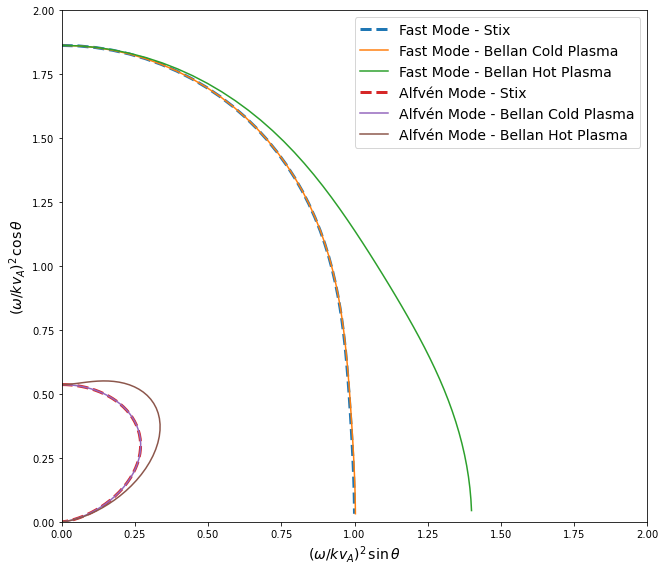

In [15]:
fig = plt.figure(figsize=[figwidth, figheight])

mode="fast_mode"
plt.plot(plt_stix[mode][0,...], plt_stix[mode][1,...], "--", linewidth=3, label="Fast Mode - Stix")
plt.plot(plt_tf_cold[mode][0,...], plt_tf_cold[mode][1,...], label="Fast Mode - Bellan Cold Plasma")
plt.plot(plt_tf_hot[mode][0,...], plt_tf_hot[mode][1,...], label="Fast Mode - Bellan Hot Plasma")

mode="alfven_mode"
plt.plot(plt_stix[mode][0,...], plt_stix[mode][1,...], "--", linewidth=3, label="Alfvén Mode - Stix")
plt.plot(plt_tf_cold[mode][0,...], plt_tf_cold[mode][1,...], label="Alfvén Mode - Bellan Cold Plasma")
plt.plot(plt_tf_hot[mode][0,...], plt_tf_hot[mode][1,...], label="Alfvén Mode - Bellan Hot Plasma")

plt.legend(fontsize=fs)

plt.xlabel(r"$(\omega / k v_{A})^{2} \, \sin \theta$", fontsize=fs)
plt.ylabel(r"$(\omega / k v_{A})^{2} \, \cos \theta$", fontsize=fs)
plt.xlim(0.0, 2.0)
plt.ylim(0.0, 2.0);